In [142]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision as tv
import random

from torchmetrics import Accuracy
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [143]:
dataset_path = "./datasets/"

In [144]:
epochs = 70
batch_size = 64
weight_decay = 1e-4
image_channels = 3
num_classes = 10

In [145]:
class ECGDataModule(pl.LightningDataModule):

    def __init__(self, dataset_path, batch_size=1):
        super().__init__()
        self.batch_size = batch_size
        self.dataset_path = dataset_path

    def setup(self, stage=None):
        test_trans = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Resize((32, 32), antialias=True),
            tv.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
        ])
        train_trans = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            tv.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            tv.transforms.RandomHorizontalFlip(),
        ])
        self.train = tv.datasets.CIFAR10(self.dataset_path,
                                         download=True,
                                         transform=train_trans,
                                         train=True)
        self.test = tv.datasets.CIFAR10(self.dataset_path,
                                        download=True,
                                        transform=test_trans,
                                        train=False)
        self.train_samples_len = self.train.data.shape[0]
        self.test_samples_len = self.test.data.shape[0]

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train,
                                           batch_size=self.batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True,
                                           persistent_workers=True)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test,
                                           batch_size=self.batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           drop_last=True)

    def visualize(self):
        cols = 10
        rows = 10
        _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
        for col in range(cols):
            for row in range(rows):
                idx = random.randint(0, self.train_samples_len)
                axes[row][col].imshow(self.train.data[idx])
                axes[row][col].set_title(self.train.classes[self.train.targets[idx]])
                axes[row][col].get_xaxis().set_visible(False)
                axes[row][col].get_yaxis().set_visible(False)


    def visualize_result(self, model):
        cols = 10
        rows = 10
        _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 28))
        model.eval()
        model.cpu()
        for col in range(cols):
            for row in range(rows):
                idx = random.randint(0, self.test_samples_len)
                image = self.test[idx][0]
                pred = model(image[None, :]).argmax(dim=1).detach().cpu()
                axes[row][col].imshow(self.test.data[idx])
                axes[row][col].get_xaxis().set_visible(False)
                axes[row][col].get_yaxis().set_visible(False)
                if self.test.targets[idx] == int(pred):
                    axes[row][col].set_title(
                        f"Label: {self.test.classes[self.test.targets[idx]]}\n"
                        f"Prediction: {self.test.classes[int(pred)]}")
                else:
                    axes[row][col].set_title(
                        f"Label: {self.test.classes[self.test.targets[idx]]}\n"
                        f"Prediction: {self.test.classes[int(pred)]}",
                        color="red")
        model.train()

    def dataset_info(self):
        print(f'Размер тренировочной выборки: {self.train.data.shape[0]}')
        print(f'Размер тестовой выборки: {self.test.data.shape[0]}')

Files already downloaded and verified
Files already downloaded and verified
Размер тренировочной выборки: 50000
Размер тестовой выборки: 10000


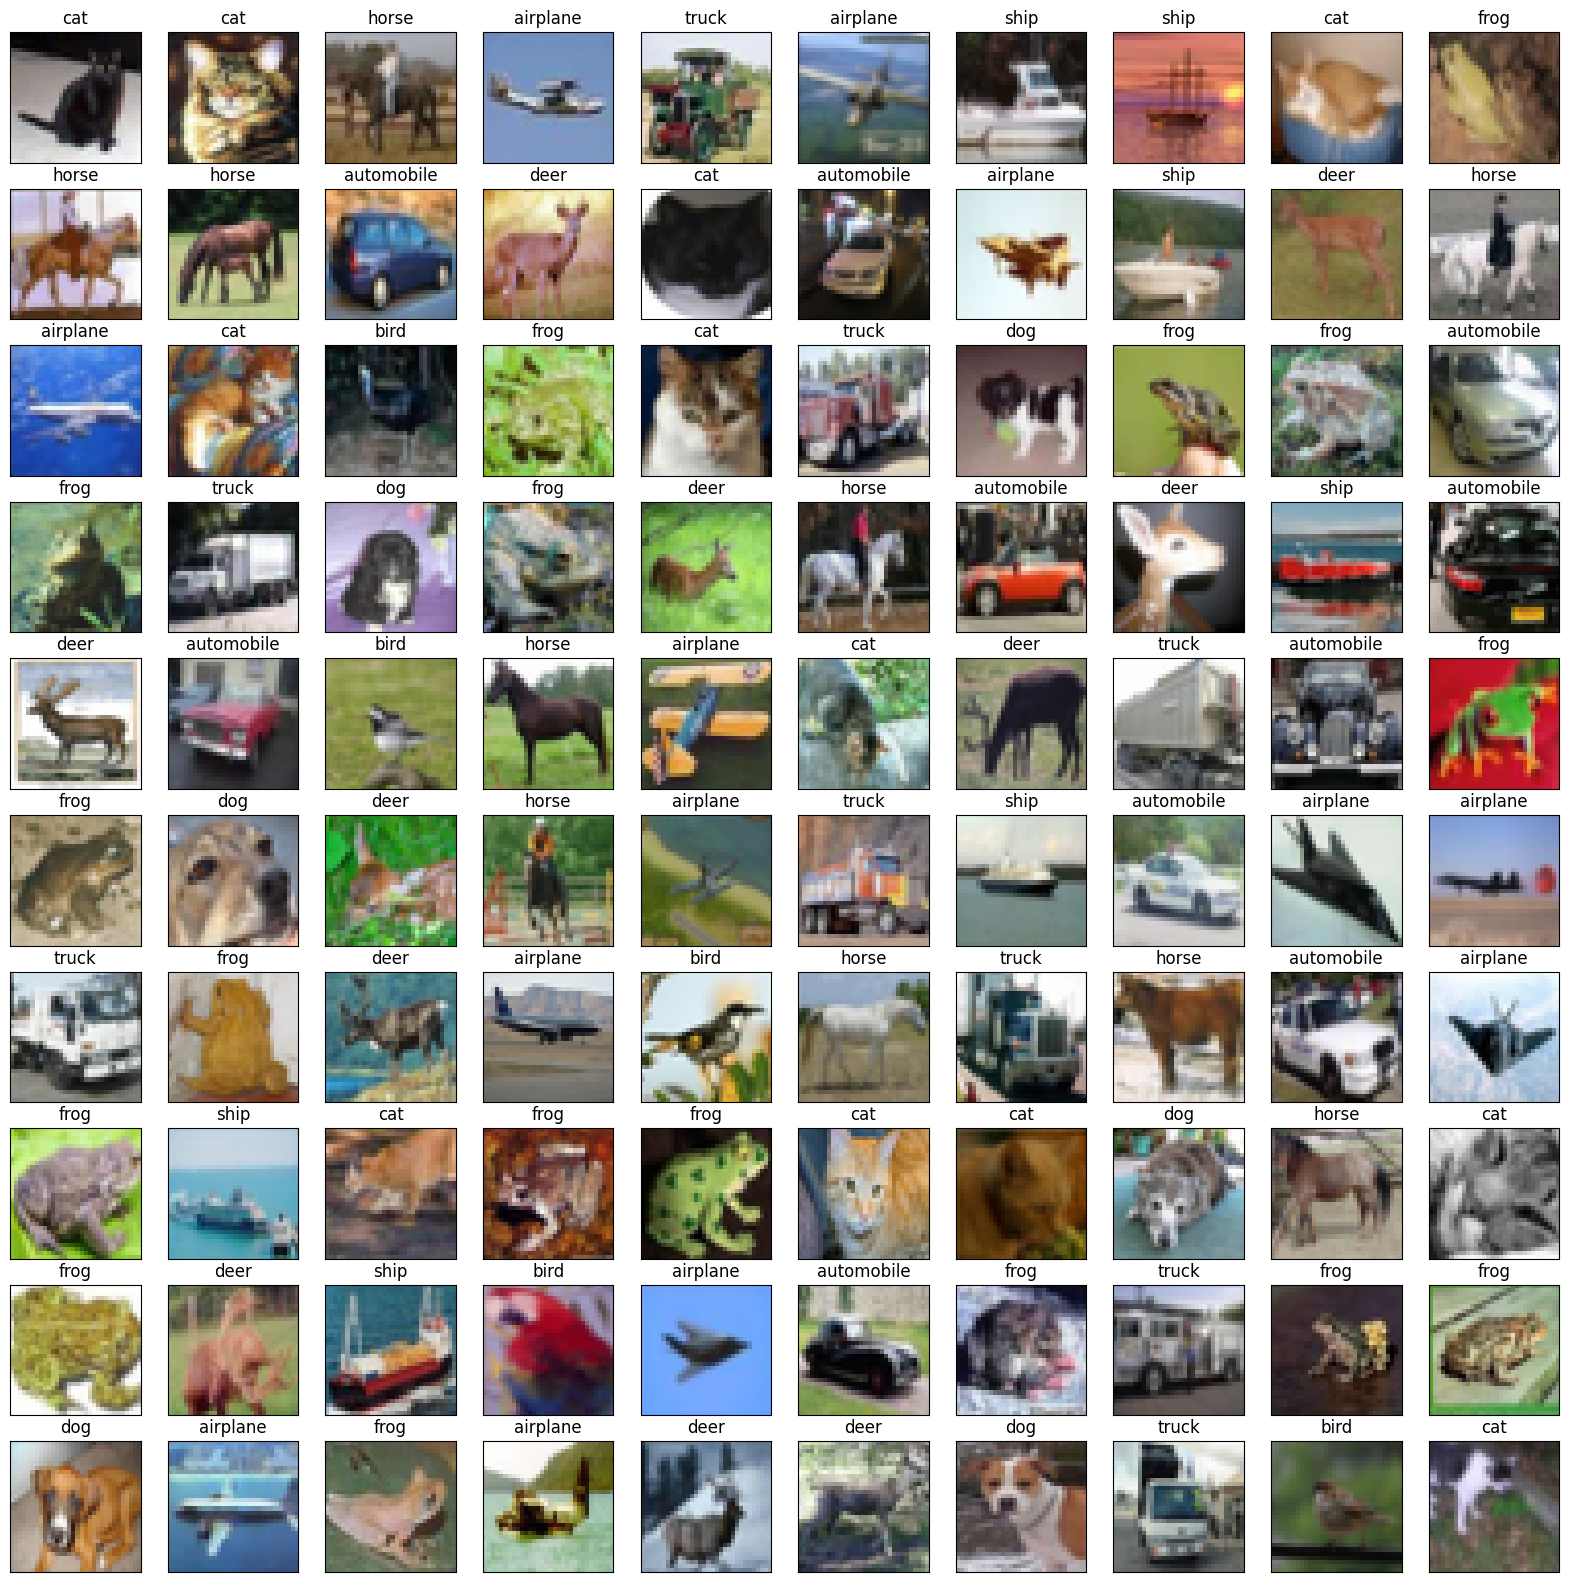

In [146]:
dm = ECGDataModule(dataset_path, batch_size)
dm.setup()
dm.dataset_info()
dm.visualize()

In [147]:
def conv_block(in_channels, num_channels, pool=False):
    layers = [
        torch.nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(num_channels),
        torch.nn.ReLU(inplace=True)
    ]
    if pool: layers.append(torch.nn.MaxPool2d(2))
    return torch.nn.Sequential(*layers)


class ResNet(torch.nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = torch.nn.Sequential(conv_block(128, 128),
                                        conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = torch.nn.Sequential(conv_block(512, 512),
                                        conv_block(512, 512))

        self.classifier = torch.nn.Sequential(
            torch.nn.MaxPool2d(4), torch.nn.Flatten(),
            torch.nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [148]:
class MyNetwork(pl.LightningModule):

    def __init__(self,
                 input_channels,
                 num_classes,
                 lr=0.0002,
                 b1=0.5,
                 b2=0.999,
                 weight_decay=0):

        super().__init__()

        self.save_hyperparameters()
        self.my_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        self.input_channels = input_channels
        self.num_classes = num_classes
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.weight_decay = weight_decay

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.network = ResNet(self.input_channels, self.num_classes)

        self.preds_stage = {
            "train": {
                "loss": [],
                "accuracy": []
            },
            "test": {
                "loss": [],
                "accuracy": []
            }
        }
        self.metrics = {
            "accuracy":
            Accuracy(task="multiclass",
                     num_classes=self.num_classes).to(self.my_device)
        }

        self.mean_train_loss = []
        self.mean_train_acc = []

    def forward(self, x):
        return self.network(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.lr,
                                      betas=(self.b1, self.b2),
                                      weight_decay=self.weight_decay)
        scheduler_dict = {
            "scheduler":
            torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3),
            "interval":
            "epoch",
            "monitor":
            "train_loss"
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

    def shared_step(self, sample, stage):
        x, y = sample
        preds = self.forward(x)
        loss = self.loss_func(preds, y)
        self.preds_stage[stage]['loss'].append(loss.detach().cpu())
        self.preds_stage[stage]['accuracy'].append(self.metrics["accuracy"](
            preds.argmax(dim=1), y).detach().cpu())
        return loss

    def shared_epoch_end(self, stage):
        loss = self.preds_stage[stage]['loss']
        loss = torch.stack(loss)
        loss = np.mean([x.item() for x in loss])
        if stage=="train":
            self.mean_train_loss.append(loss)

        acc = self.preds_stage[stage]['accuracy']
        acc = torch.stack(acc)
        acc = np.mean([x.item() for x in acc])
        if stage=="train":
            self.mean_train_acc.append(acc)

        metrics = {f"{stage}_loss": loss, f"{stage}_acc": acc}

        self.log_dict(metrics, prog_bar=True)

        self.preds_stage[stage]['loss'].clear()
        self.preds_stage[stage]['accuracy'].clear()

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        self.shared_epoch_end("train")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        self.shared_epoch_end("test")

    def train_loss_plot(self):
        plt.plot(self.mean_train_loss)
        plt.xlabel('Epochs')
        plt.ylabel('Train Loss')
        plt.grid(True)
        plt.show()

    def train_acc_plot(self):
        plt.plot(self.mean_train_acc)
        plt.xlabel('Epochs')
        plt.ylabel('Train Accuracy')
        plt.grid(True)
        plt.show()


In [149]:
model = MyNetwork(image_channels, num_classes, weight_decay)

callbacks = [
    ModelCheckpoint(dirpath='./weights/',
                    filename='{epoch}_{train_loss:.2f}',
                    save_top_k=2,
                    save_last=True,
                    monitor='train_loss',
                    mode='min',
                    enable_version_counter=False)
]

logger = TensorBoardLogger("./logs/", name="myresnet")

trainer = pl.Trainer(accelerator="gpu",
                     max_epochs=epochs,
                     logger=logger,
                     callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [150]:
checkpoint = None
trainer.fit(model, dm, ckpt_path=checkpoint)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | loss_func | CrossEntropyLoss | 0      | train
1 | network   | ResNet           | 6.6 M  | train
-------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.301    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Epoch 69: 100%|██████████| 781/781 [00:20<00:00, 37.53it/s, v_num=6, train_loss=0.0226, train_acc=0.993]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 781/781 [00:21<00:00, 36.55it/s, v_num=6, train_loss=0.0226, train_acc=0.993]


In [151]:
best_model_weights = "./weights/last.ckpt"
trainer.test(model, dm, ckpt_path=best_model_weights)

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at ./weights/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./weights/last.ckpt


Testing DataLoader 0: 100%|██████████| 156/156 [00:02<00:00, 72.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9126602411270142     │
│         test_loss         │    0.3385566771030426     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3385566771030426, 'test_acc': 0.9126602411270142}]

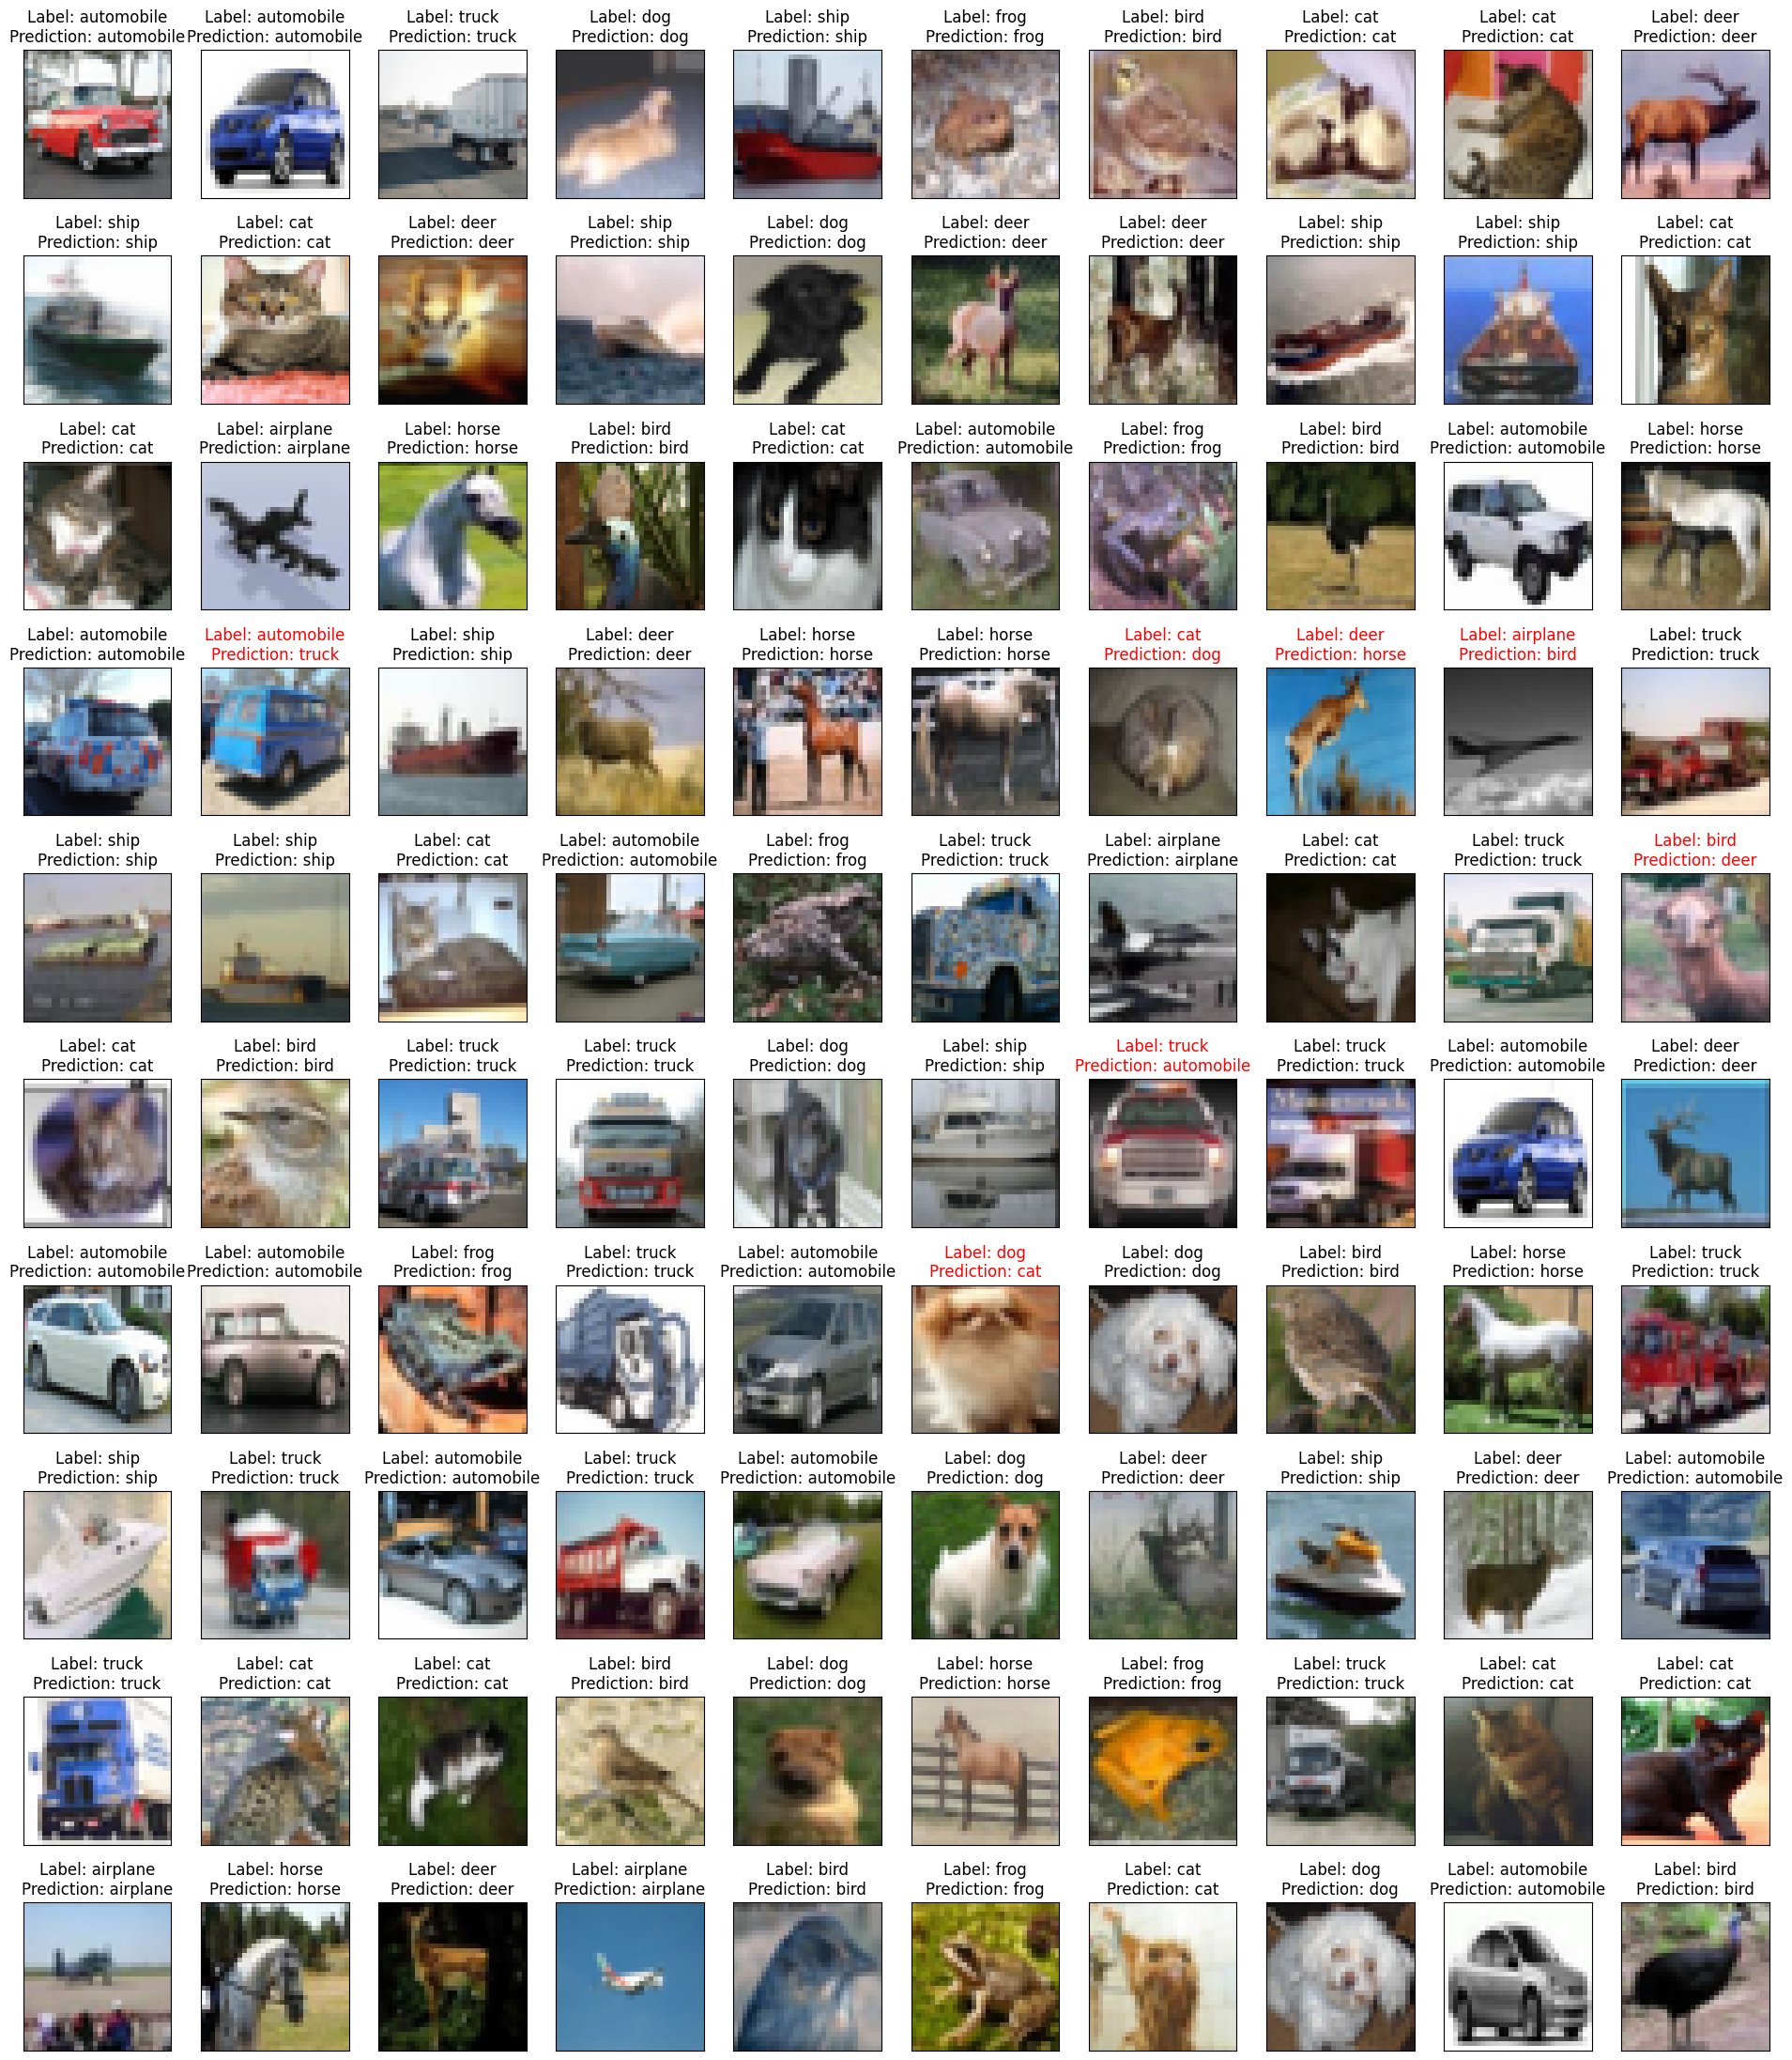

In [152]:
best_model = MyNetwork.load_from_checkpoint(best_model_weights)
dm.visualize_result(best_model)

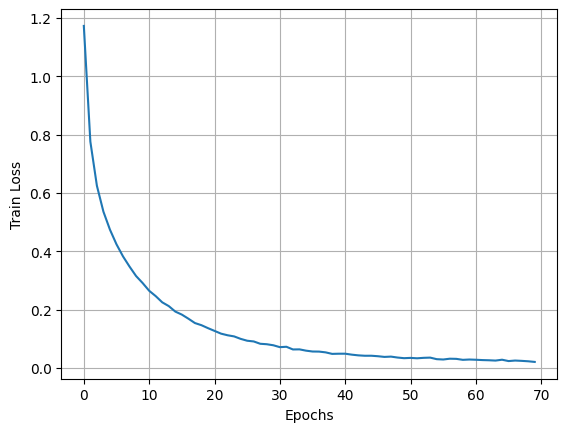

In [153]:
model.train_loss_plot()

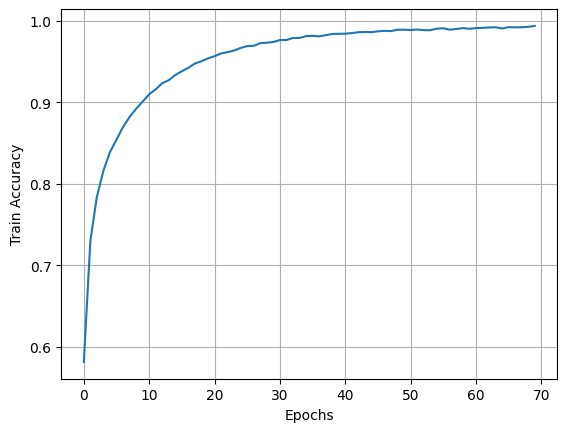

In [154]:
model.train_acc_plot()

In [157]:
%reload_ext tensorboard
%tensorboard --logdir ./logs/

Reusing TensorBoard on port 6006 (pid 14944), started 4:34:03 ago. (Use '!kill 14944' to kill it.)